In [1]:
import sys
if "../" not in sys.path:  # to get my usual helpers at base dir
    sys.path.append("../")

import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences
import lightkurve_ext as lke
from lightkurve_ext import TransitTimeSpec, TransitTimeSpecList
import lightkurve_ext_tess as lket
import lightkurve_ext_pg as lke_pg
import lightkurve_ext_pg_runner as lke_pg_runner
import tic_plot as tplt

import asyncio_compat

import math
import re
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from astropy.io import fits

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator)

from importlib import reload # useful during development to reload packages

from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7


# No longer works in Jupyter 7+
display(Javascript("""
// export notebook url to Python for bokeh-based interactive features
if (window["IPython"] != null) {
  IPython.notebook.kernel.execute(`notebook_url = "${window.location.origin}"`);
} else {
  console.warn("IPython js object not available (in Jupyter 7). Hardcode notebook_url in the notebook itself instead.")
}
"""));
notebook_url = "localhost:8888"

%matplotlib inline

# data cache config
lk_download_dir = '../data'
if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir

# make markdown table aligned to the left of the cell output (instead of center)
display(HTML("<style>table {margin-left: 4ch;}</style>"))

<IPython.core.display.Javascript object>

# TIC 721936129 Analysis (EA)

Meant to update the VSX entry for **ASASSN-V J062350.06+314059.7** : https://www.aavso.org/vsx/index.php?view=detail.top&oid=727741

3 stars in questions.
- Star A / TIC 400621146, has  ready-made 2 minute cadence lightcurves from TESS
- Star B / TIC 400621142, or ASASSN-V J062350.06+314059.7, is the one identified in VSX 
- Star C / TIC 721936129, is the actual variability source based on this analysis
 

| Star | ZTF DR20 oid   | TESS          | Gaia                       | GMag | Separation |
| ---- | -------------- | ------------- | -------------------------- | ---- | ---------- |
| A    |                | TIC 400621146 | Gaia DR3 3438744335522402944 | 13.1 | 0"         |
| B    | 660106400019014 | TIC 400621142 | Gaia DR3 3438744331224091648 | 12.3 | 17.8"       |
| C    | 660106400019009 | TIC 721936129 | Gaia DR3 3438744335522400896 | 14.9 | 19.1"       |



## Analysis to identify TIC 721936129 is the source of the variability

1. ZTF data: 
[ZTF DR20](https://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-scan?submit=Select&projshort=ZTF), oid 660106400019009, supports it.

2. Centroid Offset Analysis from TESS: 
TESS TCEs, e.g. from the [TCE for sectors 20 - 60](https://exo.mast.stsci.edu/exomast_planet.html?planet=TIC400621146S0014S0060TCE1) ([mini report](https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:TESS/product/tess2019199201929-s0014-s0060-0000000400621146-00692_dvm.pdf)), also supports it.

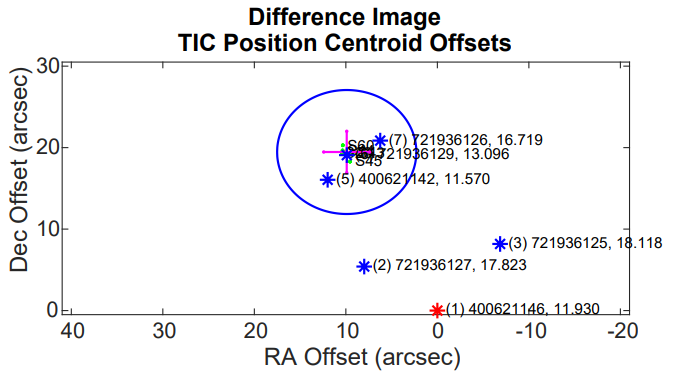

TESS Sector observation date for reference:  https://heasarc.gsfc.nasa.gov/docs/tess/sector.html

3. [Gaia DR3 Variable](https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ65bebb508f349&-out.add=.&-source=I/358/veb&recno=474381&-out.orig=o) , for Gaia DR3 3438744335522400896, identifies the target as an EB.
The suggested period, ~0.30 day, is different though. The amplitude of ~0.59 Gaia GMag is comparable, however.

4. Note: [ASAS-SN Variable](https://asas-sn.osu.edu/variables/d0ba55d8-a250-5b28-99f9-c8a57e54ab38) incorrectly attributed the variability to star B

See also: https://www.zooniverse.org/projects/nora-dot-eisner/planet-hunters-tess/talk/2112/3210327?comment=5282083

In [2]:
# List of all TCEs from the nearby TIC 400621146, that has the centroid offset analysis
display(HTML(lket.get_tic_meta_in_html(400621146, download_dir=lk_download_dir)))

---

## Gaia DR3 info (coordinate, etc.)

In [3]:
rs_all_cols, rs, rs_html  = lket.search_gaiadr3_of_tics(721936129)
display(HTML(rs_html))

# from Gaia DR3
target_coord = SkyCoord(95.95788108134, 31.68409665935, unit=(u.deg, u.deg), frame="icrs")
target_coord_dict = dict(ra=target_coord.ra.value, dec=target_coord.dec.value)
primary_name = "ASASSN-V J062350.06+314059.7"  # Use the existing name in the VSX entry (it's to be an update)

flag,separation,RAJ2000,DEJ2000,RPmag,Gmag,BPmag,BP-RP,Vmag,Teff,RUWE,sepsi,epsi,NSS,Plx,pmRA,pmDE,VarFlag,RV,e_RV,IPDfmp,Dup,Source,EpochPh,EpochRV
,arcsec,deg,deg,mag,mag,mag,mag,mag,K,,,mas,,mas,mas / yr,mas / yr,,km / s,km / s,,,,,
str2,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,str48,float64,float64,float64,str34,float64,float32,int16,uint8,int64,uint8,uint8
✓,0.002,95.95788108134,31.68409665935,13.008,13.455,13.705,0.696,13.571,7680.7,0.988,0,0.000,0,0.5217,2.661,-4.693,<a target='vizier_gaia_dr3_var' href='https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ65ac1f481b91d6&-to=-4b&-from=-3&-this=-4&%2F%2Fsource=%2BI%2F358%2Fvarisum%2BI%2F358%2Fvclassre%2BI%2F358%2Fveb%2BI%2F358%2Fvcc%2BI%2F358%2Fvst&%2F%2Fc=06%3A59%3A36.3+%2B23%3A28%3A51.14&%2F%2Ftables=I%2F358%2Fvarisum&%2F%2Ftables=I%2F358%2Fvclassre&%2F%2Ftables=I%2F358%2Fvcc&%2F%2Ftables=I%2F358%2Fveb&%2F%2Ftables=I%2F358%2Fvst&-out.max=50&%2F%2FCDSportal=http%3A%2F%2Fcdsportal.u-strasbg.fr%2FStoreVizierData.html&-out.form=HTML+Table&-out.add=_r&%2F%2Foutaddvalue=default&-sort=_r&-order=I&-oc.form=sexa&-out.src=I%2F358%2Fvarisum%2CI%2F358%2Fvclassre%2CI%2F358%2Fveb%2CI%2F358%2Fvcc%2CI%2F358%2Fvst&-nav=cat%3AI%2F358%26tab%3A%7BI%2F358%2Fvarisum%7D%26tab%3A%7BI%2F358%2Fvclassre%7D%26tab%3A%7BI%2F358%2Fvcc%7D%26tab%3A%7BI%2F358%2Fveb%7D%26tab%3A%7BI%2F358%2Fvst%7D%26key%3Asource%3D%2BI%2F358%2Fvarisum%2BI%2F358%2Fvclassre%2BI%2F358%2Fveb%2BI%2F358%2Fvcc%2BI%2F358%2Fvst%26key%3Ac%3D06%3A59%3A36.3+%2B23%3A28%3A51.14%26pos%3A06%3A59%3A36.3+%2B23%3A28%3A51.14%28+60+arcsec%29%26HTTPPRM%3A&-c=&-c.eq=J2000&-c.r=+60&-c.u=arcsec&-c.geom=r&-source=&-x.rs=10&-source=I%2F358%2Fvarisum+I%2F358%2Fvclassre+I%2F358%2Fveb+I%2F358%2Fvcc+I%2F358%2Fvst&-out.orig=standard&-out=Source&Source=3438744335522400896&-out=RA_ICRS&-out=DE_ICRS&-out=TimeG&-out=DurG&-out=Gmagmean&-out=TimeBP&-out=DurBP&-out=BPmagmean&-out=TimeRP&-out=DurRP&-out=RPmagmean&-out=VCR&-out=VRRLyr&-out=VCep&-out=VPN&-out=VST&-out=VLPV&-out=VEB&-out=VRM&-out=VMSO&-out=VAGN&-out=Vmicro&-out=VCC&-out=SolID&-out=Classifier&-out=Class&-out=ClassSc&-out=Rank&-out=TimeRef&-out=Freq&-out=magModRef&-out=PhaseGauss1&-out=sigPhaseGauss1&-out=DepthGauss1&-out=PhaseGauss2&-out=sigPhaseGauss2&-out=DepthGauss2&-out=AmpCHP&-out=PhaseCHP&-out=ModelType&-out=Nparam&-out=rchi2&-out=PhaseE1&-out=DurE1&-out=DepthE1&-out=PhaseE2&-out=DurE2&-out=DepthE2&-out=Per&-out=T0G&-out=T0BP&-out=T0RP&-out=HG0&-out=HG1&-out=HG2&-out=HG3&-out=HG4&-out=HG5&-out=HBP0&-out=HBP1&-out=HBP2&-out=HBP3&-out=HBP4&-out=HBP5&-out=HRP0&-out=HRP1&-out=HRP2&-out=HRP3&-out=HRP4&-out=HRP5&-out=Gmodmean&-out=BPmodmean&-out=RPmodmean&-out=Mratiomin&-out=alpha&-out=Ampl&-out=NfoVTrans&-out=FoVAbbemean&-out=NTimeScale&-out=TimeScale&-out=Variogram&-meta.ucd=2&-meta=1&-meta.foot=1&-usenav=1&-bmark=GET'>VARIABLE,--,--,12,0,<a target='vizier_gaia_dr3' href='https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ6578bb1b54eda&-to=-4b&-from=-4&-this=-4&%2F%2Fsource=I%2F355%2Fgaiadr3&%2F%2Ftables=I%2F355%2Fgaiadr3&%2F%2Ftables=I%2F355%2Fparamp&-out.max=50&%2F%2FCDSportal=http%3A%2F%2Fcdsportal.u-strasbg.fr%2FStoreVizierData.html&-out.form=HTML+Table&%2F%2Foutaddvalue=default&-order=I&-oc.form=sexa&-out.src=I%2F355%2Fgaiadr3%2CI%2F355%2Fparamp&-nav=cat%3AI%2F355%26tab%3A%7BI%2F355%2Fgaiadr3%7D%26tab%3A%7BI%2F355%2Fparamp%7D%26key%3Asource%3DI%2F355%2Fgaiadr3%26HTTPPRM%3A&-c=&-c.eq=J2000&-c.r=++2&-c.u=arcmin&-c.geom=r&-source=&-x.rs=10&-source=I%2F355%2Fgaiadr3+I%2F355%2Fparamp&-out.orig=standard&-out=RA_ICRS&-out=DE_ICRS&-out=Source&Source=3438744335522400896&-out=Plx&-out=PM&-out=pmRA&-out=pmDE&-out=sepsi&-out=IPDfmp&-out=RUWE&-out=Dup&-out=Gmag&-out=BPmag&-out=RPmag&-out=BP-RP&-out=RV&-out=e_RV&-out=VarFlag&-out=NSS&-out=XPcont&-out=XPsamp&-out=RVS&-out=EpochPh&-out=EpochRV&-out=MCMCGSP&-out=MCMCMSC&-out=Teff&-out=logg&-out=%5BFe%2FH%5D&-out=Dist&-out=A0&-out=HIP&-out=PS1&-out=SDSS13&-out=SKYM2&-out=TYC2&-out=URAT1&-out=AllWIS

In [4]:
#
# Tentative Eclipse parameters, from s0002-s0072:TCE1 above
#

epoch_time_btjd = 1842.7624
duration_hr = 7.3728
period = 1.651168

epoch_time_hjd = lke.to_hjd_utc(Time(epoch_time_btjd, format="btjd"), target_coord).value
epoch_time_hjd = round(epoch_time_hjd, 3)  # for VSX reporting, 3 digit precision (~1.44 min) is more than enough

## ZTF data

<Quantity 0.59326017 mag>

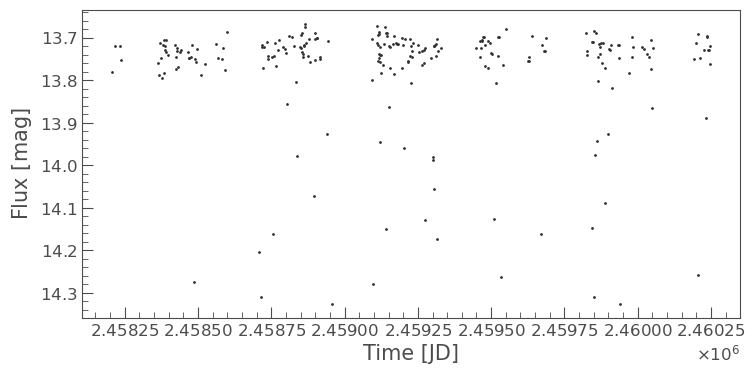

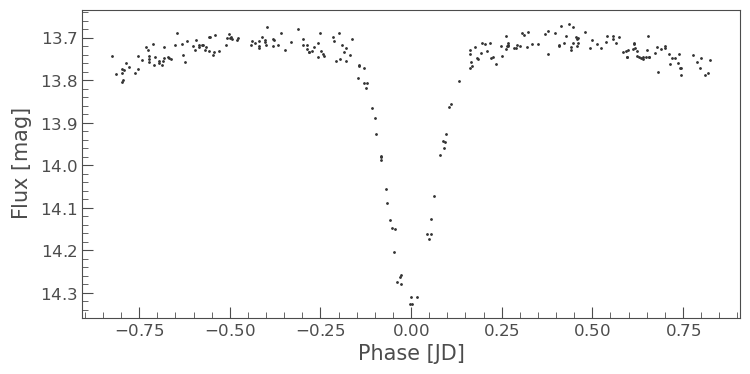

In [6]:
import lightkurve_ext_readers as lker
# reload(lker)

def read_ztf_data():
    lc = lker.read_ztf_csv(f"{lk_download_dir}/targets/tic721936129_ztfdr20_oid660106400019009.csv")
    lc.meta.update({
        "AUTHOR": "ZTF_DR20",
        
    });
    return lc

lc_ztf = read_ztf_data()
ax = tplt.scatter(lc_ztf);

lc_ztf_f = lc_ztf.fold(epoch_time=epoch_time_hjd, period=period)
ax = tplt.scatter(lc_ztf_f);

np.nanpercentile(lc_ztf.flux, 99.9) - np.median(lc_ztf.flux)  # the appxroimate depth of primary eclipse

## TESS Data for the nearby star TIC 400621146

primarily for epoch / period

In [9]:
sr = lk.search_lightcurve("TIC400621146", author="SPOC", cadence="short")
display(sr)

lcc_tess = sr.download_all()
lcc_tess

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 20,2019,SPOC,120,400621146,0.0,N/A
1,TESS Sector 43,2021,SPOC,120,400621146,0.0,"G04171 , G04214"
2,TESS Sector 44,2021,SPOC,120,400621146,0.0,"G04171 , G04214"
3,TESS Sector 45,2021,SPOC,120,400621146,0.0,"G04171 , G04214"
4,TESS Sector 60,2022,SPOC,120,400621146,0.0,"G05152 , G05003"
5,TESS Sector 71,2023,SPOC,120,400621146,0.0,G06057
6,TESS Sector 72,2023,SPOC,120,400621146,0.0,G06057
7,TESS Sector 73,2023,SPOC,120,400621146,0.0,G06057


LightCurveCollection of 8 objects:
    0: <TessLightCurve LABEL="TIC 400621146" SECTOR=20 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 400621146" SECTOR=43 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 400621146" SECTOR=44 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    3: <TessLightCurve LABEL="TIC 400621146" SECTOR=45 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    4: <TessLightCurve LABEL="TIC 400621146" SECTOR=60 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    5: <TessLightCurve LABEL="TIC 400621146" SECTOR=71 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    6: <TessLightCurve LABEL="TIC 400621146" SECTOR=72 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    7: <TessLightCurve LABEL="TIC 400621146" SECTOR=73 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>

## Rough Crowding correction (on TESS data)

- Use TESS data only as it has less spatial resolution. So the aperture of the contaminated lightcurve has proportionally more flux from the actual target.

In [42]:
sr_tpf = lk.search_targetpixelfile("TIC400621146",cadence="short")
display(sr_tpf)
tpf = sr_tpf[0].download();

tpf.interact_sky(notebook_url=notebook_url, aperture_mask="pipeline");

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 20,2019,SPOC,120,400621146,0.0,N/A
1,TESS Sector 43,2021,SPOC,120,400621146,0.0,"G04171 , G04214"
2,TESS Sector 44,2021,SPOC,120,400621146,0.0,"G04171 , G04214"
3,TESS Sector 45,2021,SPOC,120,400621146,0.0,"G04171 , G04214"
4,TESS Sector 60,2022,SPOC,120,400621146,0.0,"G05152 , G05003"
5,TESS Sector 71,2023,SPOC,120,400621146,0.0,G06057
6,TESS Sector 72,2023,SPOC,120,400621146,0.0,G06057
7,TESS Sector 73,2023,SPOC,120,400621146,0.0,G06057
8,TESS Sector 20,2019,TESS-SPOC,1800,400621146,0.0,N/A


The 3 stars in the TESS aperture

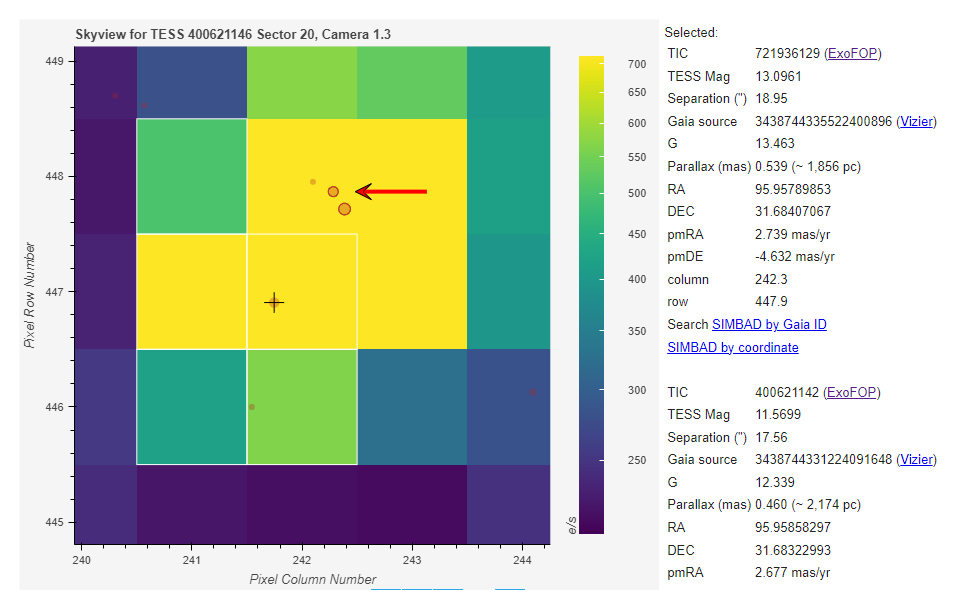


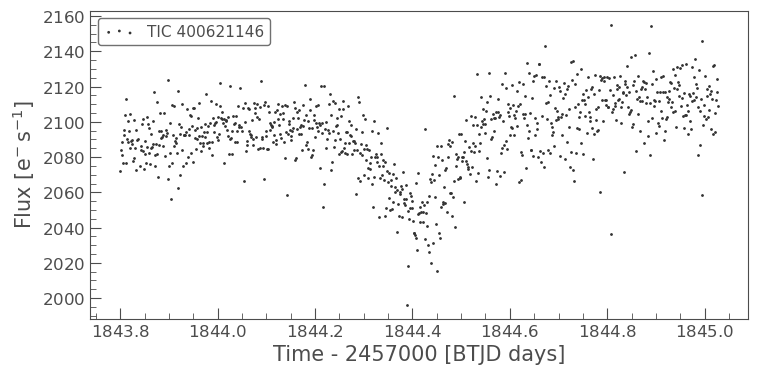

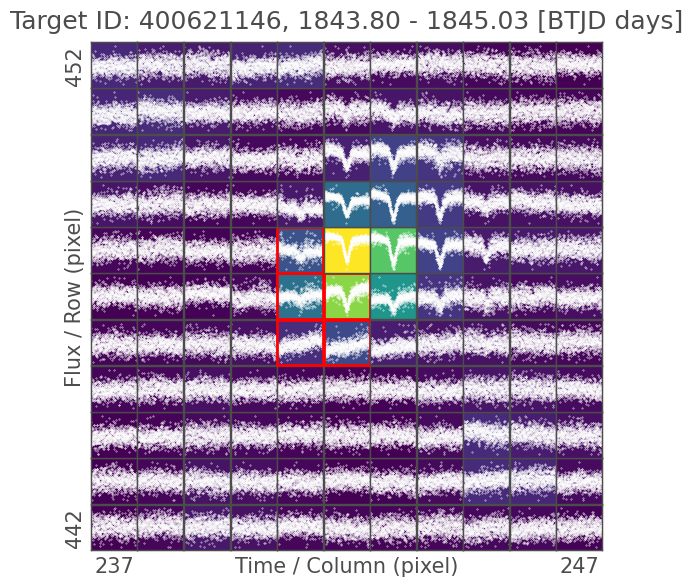

In [67]:
t0 = epoch_time_btjd  + period * 1  # choose a dip that is
tpf_trunc = lke.truncate(tpf,  t0 - duration_hr / 24 * 2, t0 + duration_hr / 24 * 2)
tpf_trunc.to_lightcurve().scatter();

pixel_size_inches, markersize = 0.6, 0.6
ax = tplt.lk_ax(figsize=(tpf_trunc.flux[0].shape[1] * pixel_size_inches, tpf_trunc.flux[0].shape[0] * pixel_size_inches))
tpf_trunc.plot_pixels(ax=ax, markersize=markersize, show_flux=True, aperture_mask="pipeline");

### Determine the relative flux of the target in the aperture, and construct crowding corrected Lightcurve

In [44]:
# The 3 TICs in the aperture

tics = [ 400621146,   # the TESS lc's target
        400621142,  # the other star
        721936129,  # the actual variability source to be reported
]

tic_rs = lket.catalog_info_of_tics(tics)
# 12.3083: Tmag of TIC 242942524, the brightest one with pre-built lightcurves in TESS / K2
tic_rs["Relative_Flux"] = 1 / 2.51 **(tic_rs["Tmag"] - 11.5699)

display(HTML("""Column Descriptions in:
<a href="https://outerspace.stsci.edu/display/TESS/TIC+v8.2+and+CTL+v8.xx+Data+Release+Notes" target="_tic_columns_doc">Data Release Notes</a> |
<a href="https://vizier.cds.unistra.fr/viz-bin/VizieR?-source=IV/39" target="_tic_vizier" title="Vizier seems to have more complete information about various flag values.">Vizier table</a>
"""))
display(
    tic_rs['ID',
           'Tmag',
           'Relative_Flux',
           'Vmag',
           'VmagFlag',  # source of Vmag
           'GAIA', 'TWOMASS', 'disposition', 'duplicate_id',
          ]
)

ID,Tmag,Relative_Flux,Vmag,VmagFlag,GAIA,TWOMASS,disposition,duplicate_id
str9,float64,float64,float64,str5,str19,str16,str1,str1
400621146,11.9302,0.7177902554365511,14.288,ucac4,3438744335522402944,06234934+3140515,--,--
721936129,13.0961,0.24548104663403345,13.5723,gaia2,3438744335522400896,--,--,--
400621142,11.5699,1.0,12.46,ucac4,3438744331224091648,06235004+3140597,--,--


The crowing correction is very rough and should **NOT** be used for determining amplitude

- Should have used `SAP_FLUX` to create crowding corrected lightcurve
- but `SAP_FLUX` requires additional calibration (inconsistent median flux) to be used before considering crowding correction
- For expediencey, `PDCSAP_FLUX` is used, and rough guesses on `CROWDSAP`, `FLFRCSAP` are used such that the amplitude roughly match ZTF amplitude
- It's done so that the 2 datasets can be combined for the purpose of period identification

### Scaled TESS Lightcurve

- Not a strict crowding corrected one, a rough approximation

C:\dev\_juypter\PH_TESS_LightCurveViewer\targets\..\lightkurve_ext.py:1056: UserWarning: correct_crowding(): supplied lightcurve is likely not SAP based, with FLUX_ORIGIN: pdcsap_flux. Corrected lightcurve returned might not be valid.
  warnings.warn(


<MaskedQuantity 0.5962501 mag>

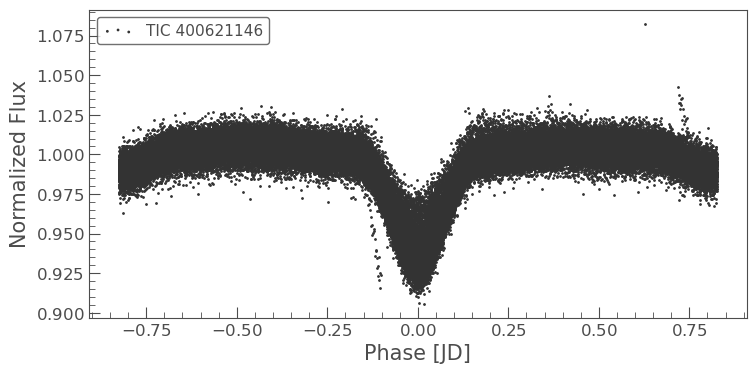

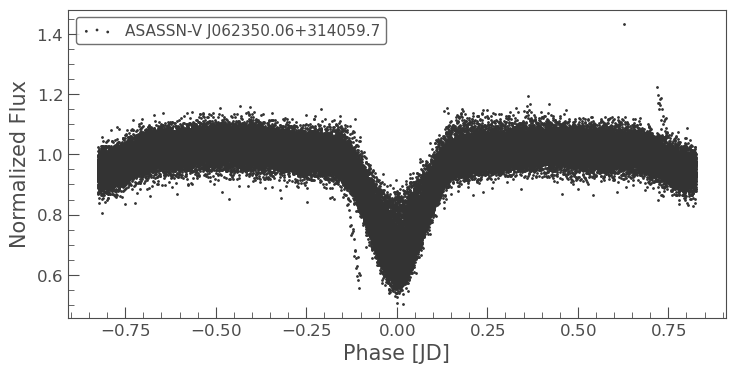

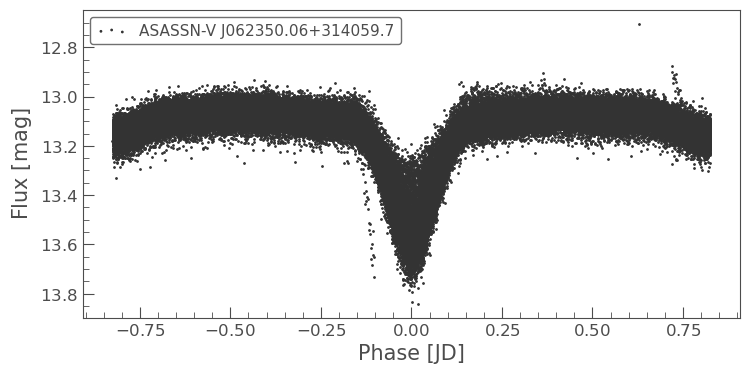

In [10]:
# estimate the ratio of the flux in the contaminated aperture that belongs to the target
# and construct a corrected lightcurve
# target_flux_ratio_in_aperture = 0.24548104663403345 / (0.7177902554365511 + 0.24548104663403345 + 1)
# print(target_flux_ratio_in_aperture)

# Note: we use SAP_FLUX as the basis for crowding correction, but
# SAP_FLUX covers fair amount of problematic cadences (mostly due to scattered light)
# To make the lightcurve cleaner, the problematic cadences
# via `.remove_nans()` on PDCSAP_FLUX.
lc_tess_contaminated = lke.stitch(lcc_tess, corrector_func=lambda lc: lc.remove_nans().select_flux("pdcsap_flux").normalize())
lc_tess_contaminated_f = lc_tess_contaminated.fold(epoch_time=epoch_time_btjd, period=period)
ax = tplt.scatter(lc_tess_contaminated_f)
# ax.set_ylim(0.98, 1.02);

# I pick the params such that the eclipse' amplitude matches the one from ZTF
lc_tess_target = lke.correct_crowding(lc_tess_contaminated, 0.19, 1).normalize()
lc_tess_target.label = primary_name
lc_tess_target.meta['TESSMAG'] = 13.0961
ax = lc_tess_target.fold(epoch_time=epoch_time_btjd, period=period).scatter();
# ax.set_ylim(0.85, 1.12);

# Now convert them to magnitude

# lc_tess_contaminated = lke.to_flux_in_mag_by_normalization(lc_tess_contaminated)
# lc_tess_contaminated_f = lc_tess_contaminated.fold(epoch_time=epoch_time_btjd, period=period)
# ax = tplt.scatter(lc_tess_contaminated_f);
# ax.set_ylim(None, 12.29);

lc_tess_target = lke.to_flux_in_mag_by_normalization(lc_tess_target)
lc_tess_target_f = lc_tess_target.fold(epoch_time=epoch_time_btjd, period=period)
ax = tplt.scatter(lc_tess_target_f);

np.nanpercentile(lc_tess_target.flux, 99.9) - np.median(lc_tess_target.flux)

# ax.set_ylim(None, 13.85);

# # Zoom-in Show the duration
# ax = tplt.scatter(lc_tess_target_f);
# ax.set_ylim(None, 13.85);
# ax.set_xlim(0 - 1.5 * duration_hr / 24, 0 + 1.5 * duration_hr / 24 );
# ax.axvline(0 - duration_hr / 24 / 2, c="b", linestyle="--");
# ax.axvline(0 + duration_hr / 24 / 2, c="b", linestyle="--");

## Combining TESS and ZTF data

TESS # data points: 119426
ZTF g # data points: 250


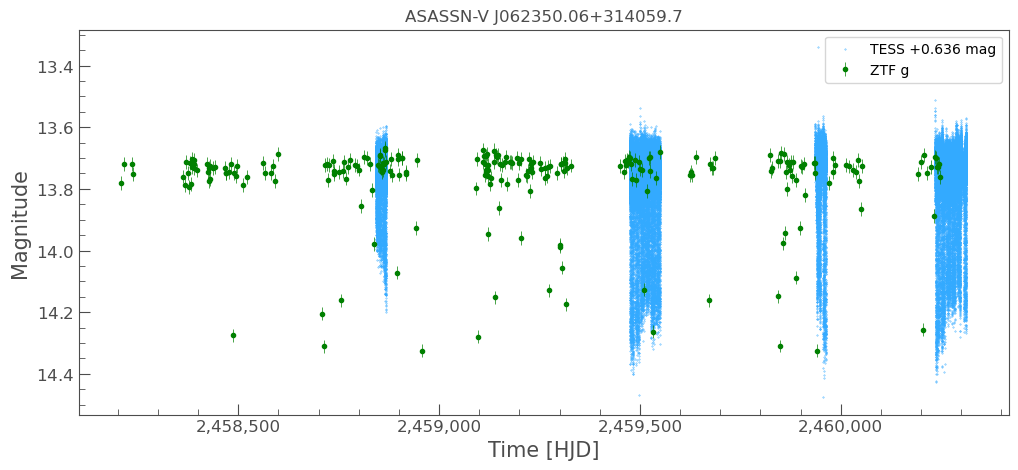

In [11]:
# Convert the data to magnitude and HJD/UTC

import lightkurve_ext_multi_sources as lkem
reload(lkem)

lc_tess = lke.convert_lc_time_to_hjd_utc(lc_tess_target, target_coord=target_coord, cache_dir=lk_download_dir)
lc_tess = lke.to_flux_in_mag_by_normalization(lc_tess)
# axs = tplt.plot_skip_data_gap(lc_tess, figsize=(30,5), s=4, alpha=0.9);

lc_combined_dict = lkem.combine_multi_bands_and_shift({"TESS": lc_tess, "ZTF g": lc_ztf}, shift_to="ZTF g")
for k in lc_combined_dict.keys():
    print(f"{k} # data points:", len(lc_combined_dict[k]))

ax = lkem.plot_tess_n_ztf(lc_combined_dict, figsize=(12, 5), target_name=primary_name);
# ax.set_ylim(None, 12.25);

## Refine period by using both TESS and ZTF data

C:\dev\_juypter\PH_TESS_LightCurveViewer\targets\..\lightkurve_ext_pg.py:350: UserWarning: validate_bls_n_report() cannot calculate FAP, because the depdent package transitleastsquares is not installed
  warnings.warn(


max power duration factor: 0.95


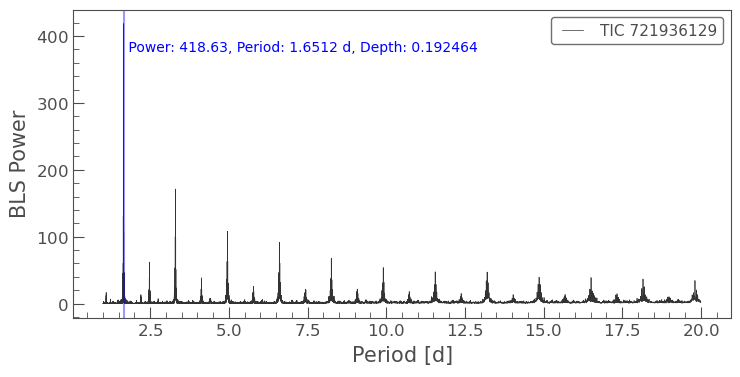

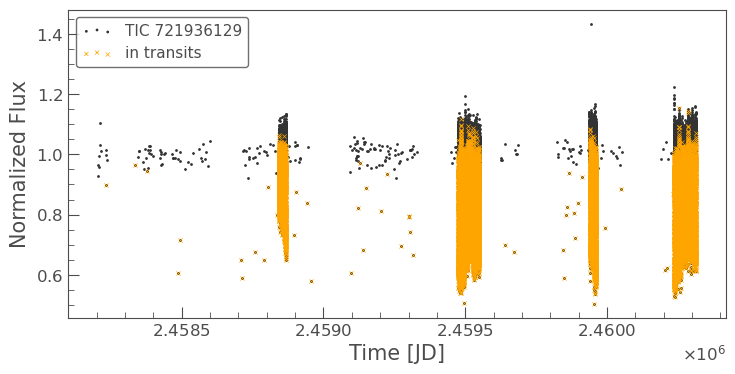

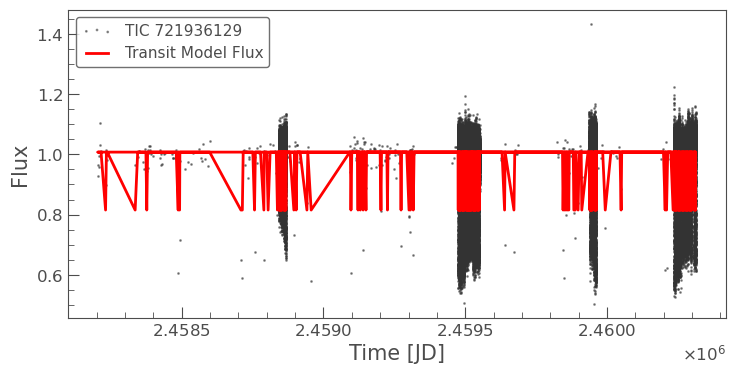

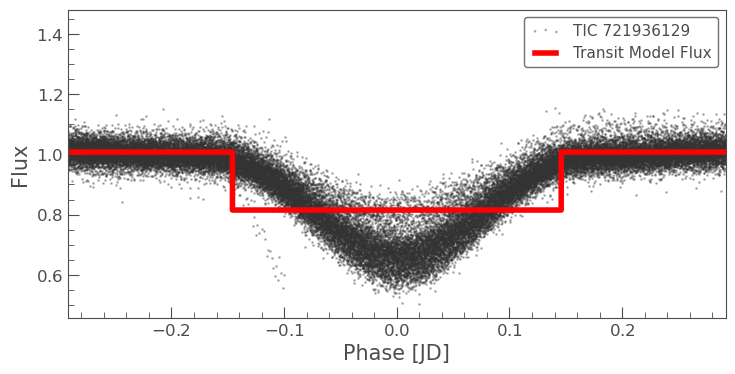

In [14]:
bls_result = lke_pg_runner.run_bls(
    # convert the TESS + ZTF lightcurve to normalized flux for BLS
    lke.to_normalized_flux_from_mag(lk.LightCurveCollection(lc_combined_dict.values()).stitch(corrector_func=lambda lc: lc)),
    pg_kwargs=dict(
        minimum_period=1,  # prevent BLS from trying to fit both primary and secondary 
        maximum_period=20,  
        frequency_factor=10,            
        duration=[duration_hr / 24 * f for f in [0.95, 0.975, 0.9875, 1, 1.0125, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
    ),
)

print("max power duration factor:", round(bls_result.pg.duration_at_max_power.to(u.h).value / duration_hr, 2))
# tplt.beep();

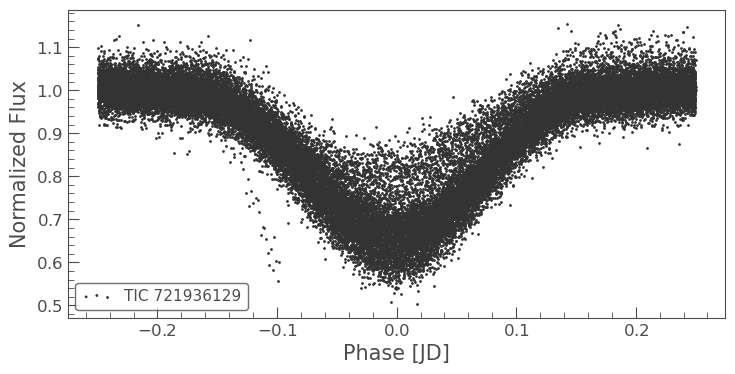

In [13]:
# export LC truncated around primary eclipses for AoV test

lc = bls_result.lc_f.truncate(-0.25, 0.25)
lc.scatter();
lk.LightCurve(time=lc.time_original, flux=lc.flux, flux_err=lc.flux_err).to_csv(f"tmp/{primary_name}_trunc_primary.csv")

119714 2108.0060496465303 2458204.6477313535 2460312.653781
Period at max: 1.6511339 d
lightkurve.Periodogram properties:
      Attribute                   Description            Units
---------------------- --------------------------------- -----
                nterms                                 1      
              targetid                         400621146      
          default_view                            period      
                 label                     TIC 721936129      
             ls_method                              fast      
frequency_at_max_power                            0.6056 1 / d
             max_power                            0.0596      
               nyquist                          359.9712 1 / d
   period_at_max_power                            1.6511     d
             frequency                    array (66712,) 1 / d
                period                    array (66712,)     d
                 power                    array (66712,)   

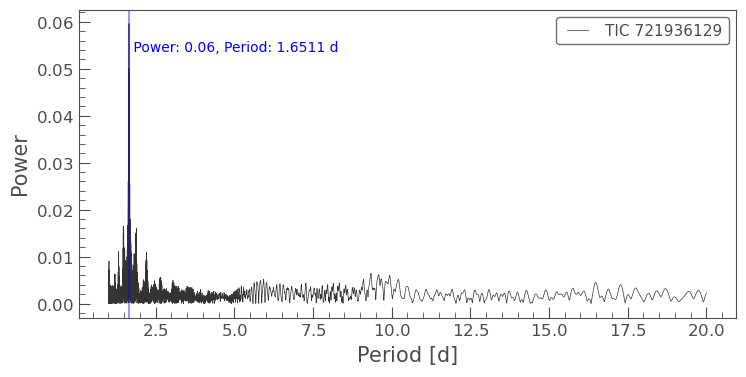

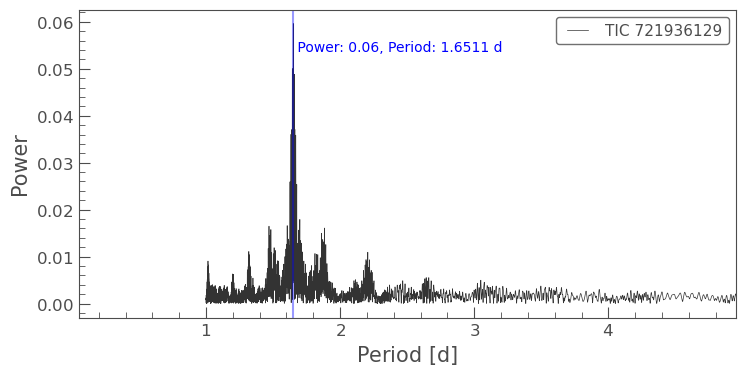

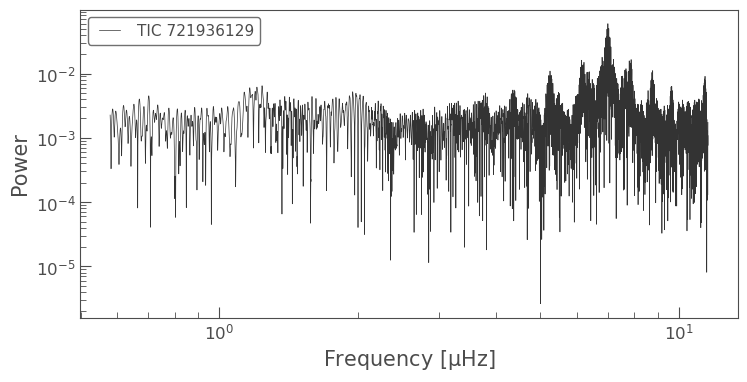

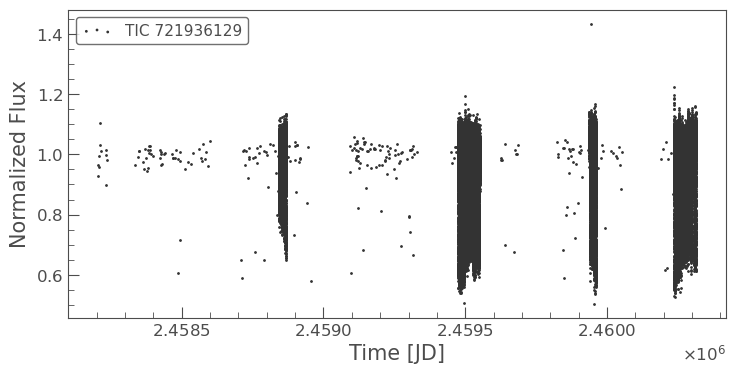

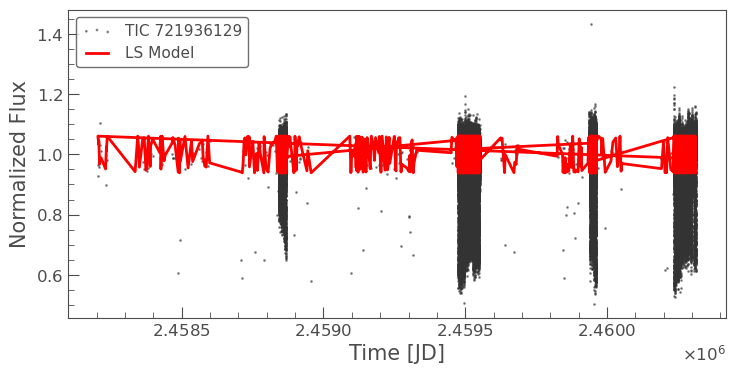

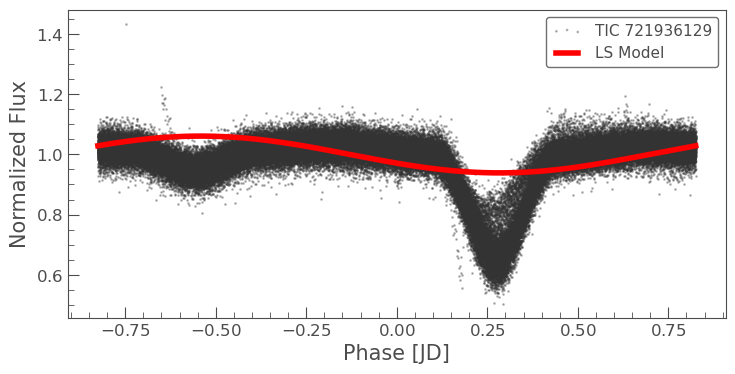

In [24]:
lc = lke.to_normalized_flux_from_mag(lk.LightCurveCollection(lc_combined_dict.values()).stitch(corrector_func=lambda lc: lc))
pg = (
    lc    
    .to_periodogram(method="lombscargle",
                     maximum_period=20,
                      minimum_period=1,                    
                    # ls_method="fastchi2", nterms=12,
                    oversample_factor=50,  # default: 5
                      )
     )
print(len(lc), lc.time.max() - lc.time.min(), lc.time.min(), lc.time.max(), )
print(f"Period at max: {pg.period_at_max_power:.7f}")
pg.show_properties();

ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=80);
# ax.set_xlim(0, 16);

# zoom in
ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=3);

# ---

# ax = pg.plot(view="frequency");  # frequency view
# ax.set_xlim(pg.frequency_at_max_power.value / 100 , pg.frequency_at_max_power.value * 10);

# frequency in log scale / microhertz
# often useful for solar type oscillator, 
ax = pg.plot(view="frequency", unit=u.microhertz, scale="log"); 

# ---

axs, lcs = lke_pg.plot_lc_with_model(
    lc.normalize(),
    pg, 
    # period=pg.period_at_max_power * 2,   # custom period
    also_return_lcs=True);

In [12]:
period_bls = 1.65117  # rounded from 1.6511698916762652, frequency_factor=10
period_aov = 1.65116  # rounded from ~1.651157 , bins=16

period_final = period_aov
print("Adopted period: ", period_final)

Adopted period:  1.65116


## Determine Eclipse Amplitude (not used)

Not used in VSX reporting in this case. Just report overall max/min, and Min II mag

14.3107157 , # data points: 5
Median mag: 13.73346375
Dip's depth: 0.5772519499999991
Mag range (no sample) 13.6663733 14.3251858 14.3107157


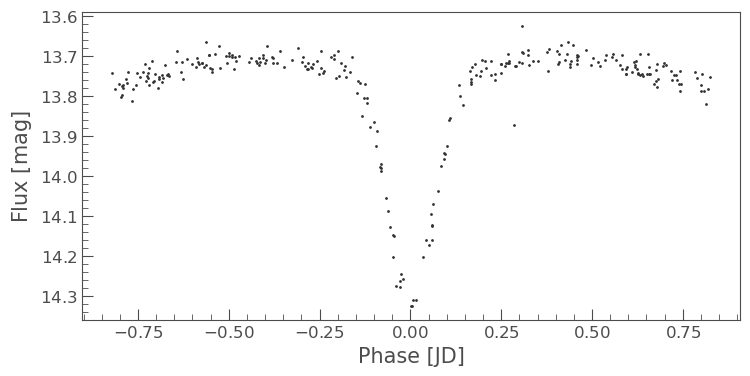

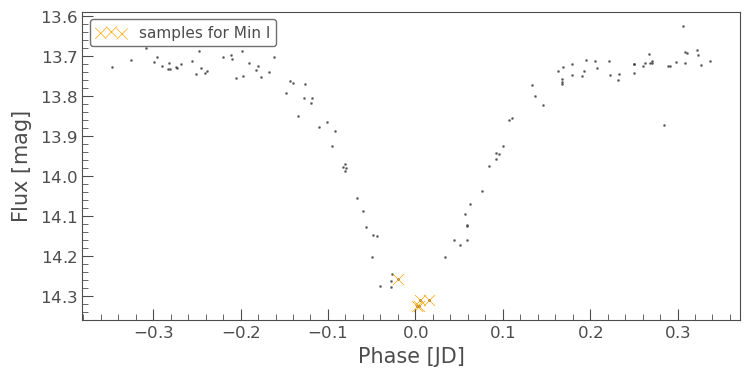

In [17]:
lc_ztf_f = lc_ztf.fold(epoch_time=epoch_time_hjd, period=period_final)
ax = tplt.scatter(lc_ztf_f);

lc_f_min_sample = lc_ztf_f.truncate(0 - 30/24/60, 0 + 30/24/60)
min_flux_sample = lc_f_min_sample.flux
min_flux_mag = np.nanmedian(min_flux_sample).value
print(min_flux_mag, ", # data points:", len(min_flux_sample))

mag_median_target = np.nanmedian(lc_ztf.flux.value)
mag_diff_target = min_flux_mag - mag_median_target
print("Median mag:", mag_median_target)
print("Dip's depth:", mag_diff_target)

ax = tplt.scatter(lc_ztf_f.truncate(-0.35, 0.35), alpha=0.6);
ax = tplt.scatter(lc_f_min_sample, ax=ax, c="orange", marker="x", s=64, label="samples for Min I");

13.78423115 , # data points: 6
Median mag: 13.73346375
Dip's depth: 0.050767399999999796


13.78423115

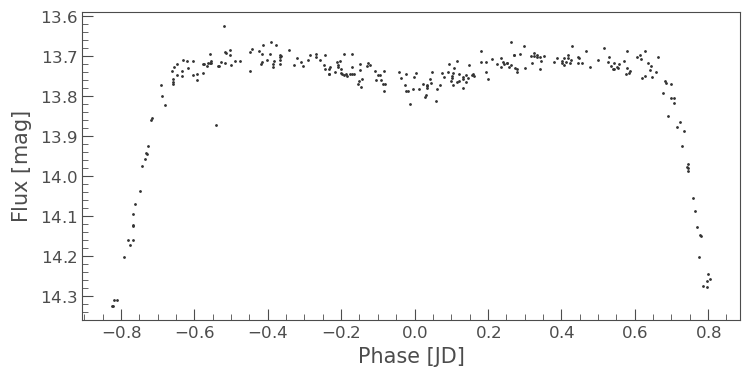

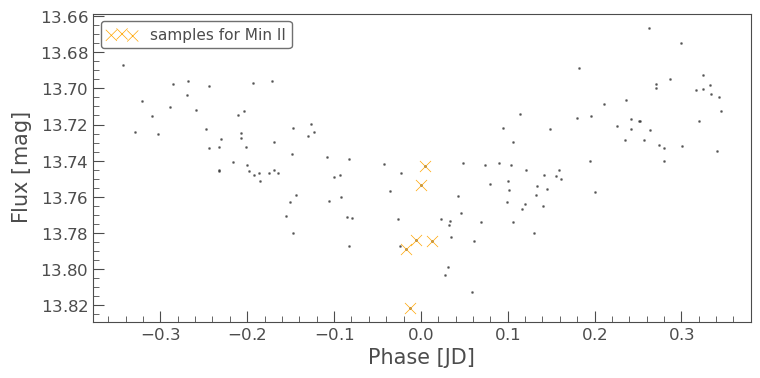

In [47]:
# Determine Min II

lc_ztf_f = lc_ztf.fold(epoch_time=epoch_time_hjd + period_final / 2, period=period_final)
ax = tplt.scatter(lc_ztf_f);

lc_f_min_sample = lc_ztf_f.truncate(0 - 30/24/60, 0 + 30/24/60)
min_flux_sample = lc_f_min_sample.flux
min_flux_mag = np.nanmedian(min_flux_sample).value
print(min_flux_mag, ", # data points:", len(min_flux_sample))

mag_median_target = np.nanmedian(lc_ztf.flux.value)
mag_diff_ii_target = min_flux_mag - mag_median_target
print("Median mag:", mag_median_target)
print("Dip's depth:", mag_diff_ii_target)

ax = tplt.scatter(lc_ztf_f.truncate(-0.35, 0.35), alpha=0.6);
ax = tplt.scatter(lc_f_min_sample, ax=ax, c="orange", marker="x", s=64, label="samples for Min II");

## Determine Amplitude (range)

['13.71', '14.33', '13.80']


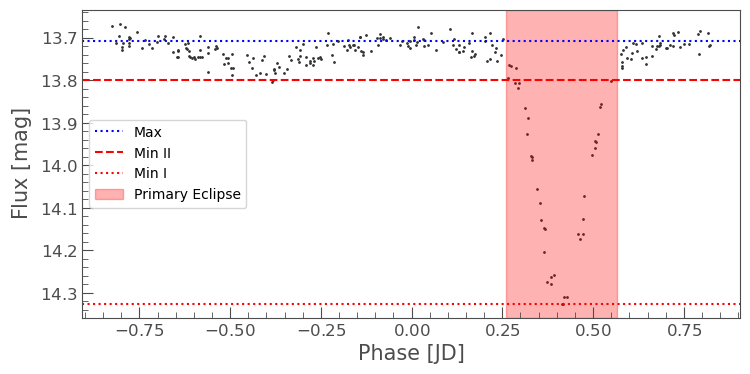

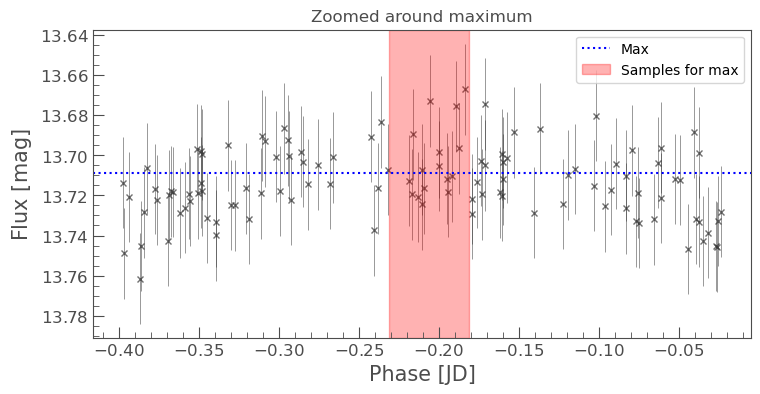

In [71]:
min_flux_mag = lc_ztf.flux.max().value

# fold around Min II, find the min flux
lc_ztf_zoom_min_ii = lc_ztf.fold(epoch_time=epoch_time_hjd + period_final / 2, period=period_final).truncate(0 - 30/24/60, 0 + 30/24/60)
min_ii_flux_mag = lc_ztf_zoom_min_ii.flux.max().value
min_ii_flux_mag = 13.80  # override from visual inspection

# fold around max 
phase_max_days = -period / 8  # around 
phase_max_plot_range = (phase_max_days - 0.2, phase_max_days + 0.2)
phase_max_sample_range = (phase_max_days - 0.025, phase_max_days + 0.025)
lc_ztf_max_f_plot = lc_ztf.fold(epoch_time=epoch_time_hjd, period=period_final / 2, epoch_phase=period_final/8)  # shift primary to phase 0.25, so that one can see both primary and secondary easily
lc_ztf_max_f_plot = lc_ztf_max_f_plot.truncate(*phase_max_plot_range)
lc_ztf_max_f_samples = lc_ztf_max_f_plot.truncate(*phase_max_sample_range)
max_flux_mag = np.median(lc_ztf_max_f_samples.flux.value)

lc_ztf_f = lc_ztf.fold(epoch_time=epoch_time_hjd, period=period_final, epoch_phase=period_final/4)  # shift primary to phase 0.25, so that one can see both primary and secondary easily
ax = tplt.scatter(lc_ztf_f);
ax.axhline(max_flux_mag, c="blue", linestyle="dotted", label="Max")
ax.axhline(min_ii_flux_mag, c="red", linestyle="dashed", label="Min II")
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
phase_min_range = (period_final / 4 - duration_hr / 2 / 24, period_final / 4 + duration_hr / 2 / 24)
ax.axvspan(*phase_min_range, color="red", alpha=0.3, label="Primary Eclipse");
ax.legend();

ax = tplt.errorbar(lc_ztf_max_f_plot, marker="x", markersize=4, alpha=0.7, zorder=-1);
ax.axhline(max_flux_mag, c="blue", linestyle="dotted", label="Max")
ax.axvspan(*phase_max_sample_range, color="red", alpha=0.3, label="Samples for max")
ax.legend();
ax.set_title("Zoomed around maximum");

print([f"{v:.2f}" for v in [max_flux_mag, min_flux_mag, min_ii_flux_mag]])

## Plots for VSX

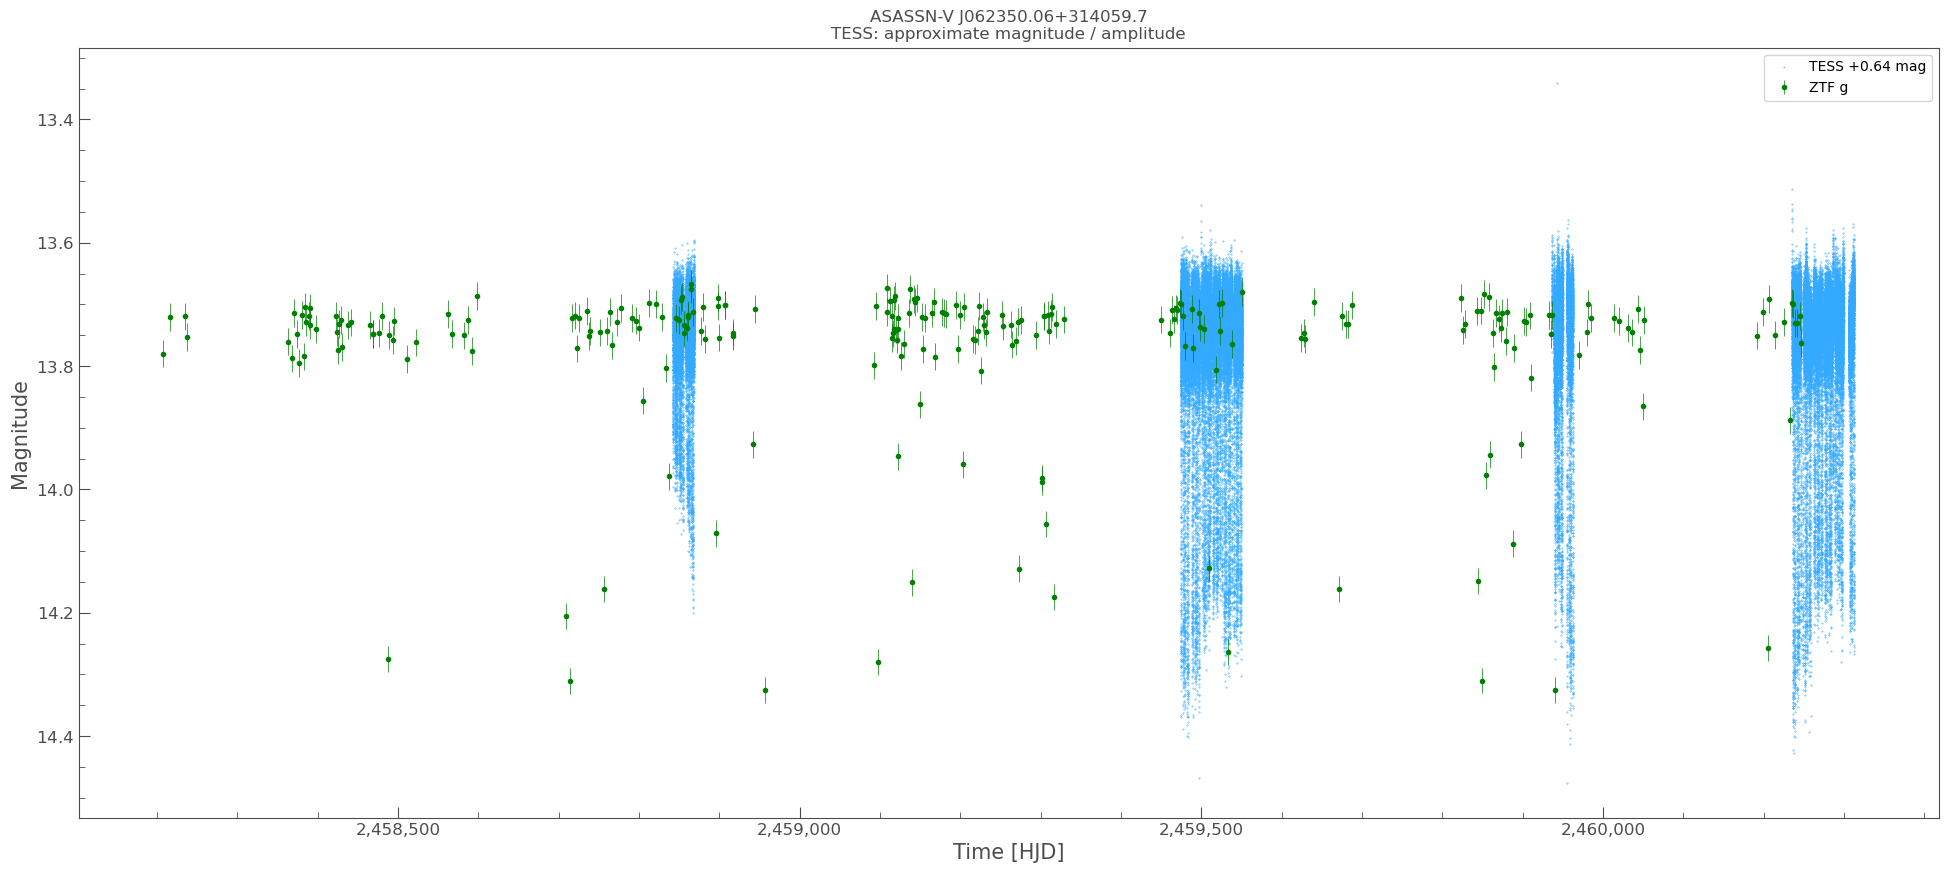

In [14]:
# reload(lkem)
ax = lkem.plot_tess_n_ztf(lc_combined_dict, figsize=(24, 10), target_name=primary_name, mag_shift_precision=2);
ax.set_title(ax.get_title() + "\nTESS: approximate magnitude / amplitude");

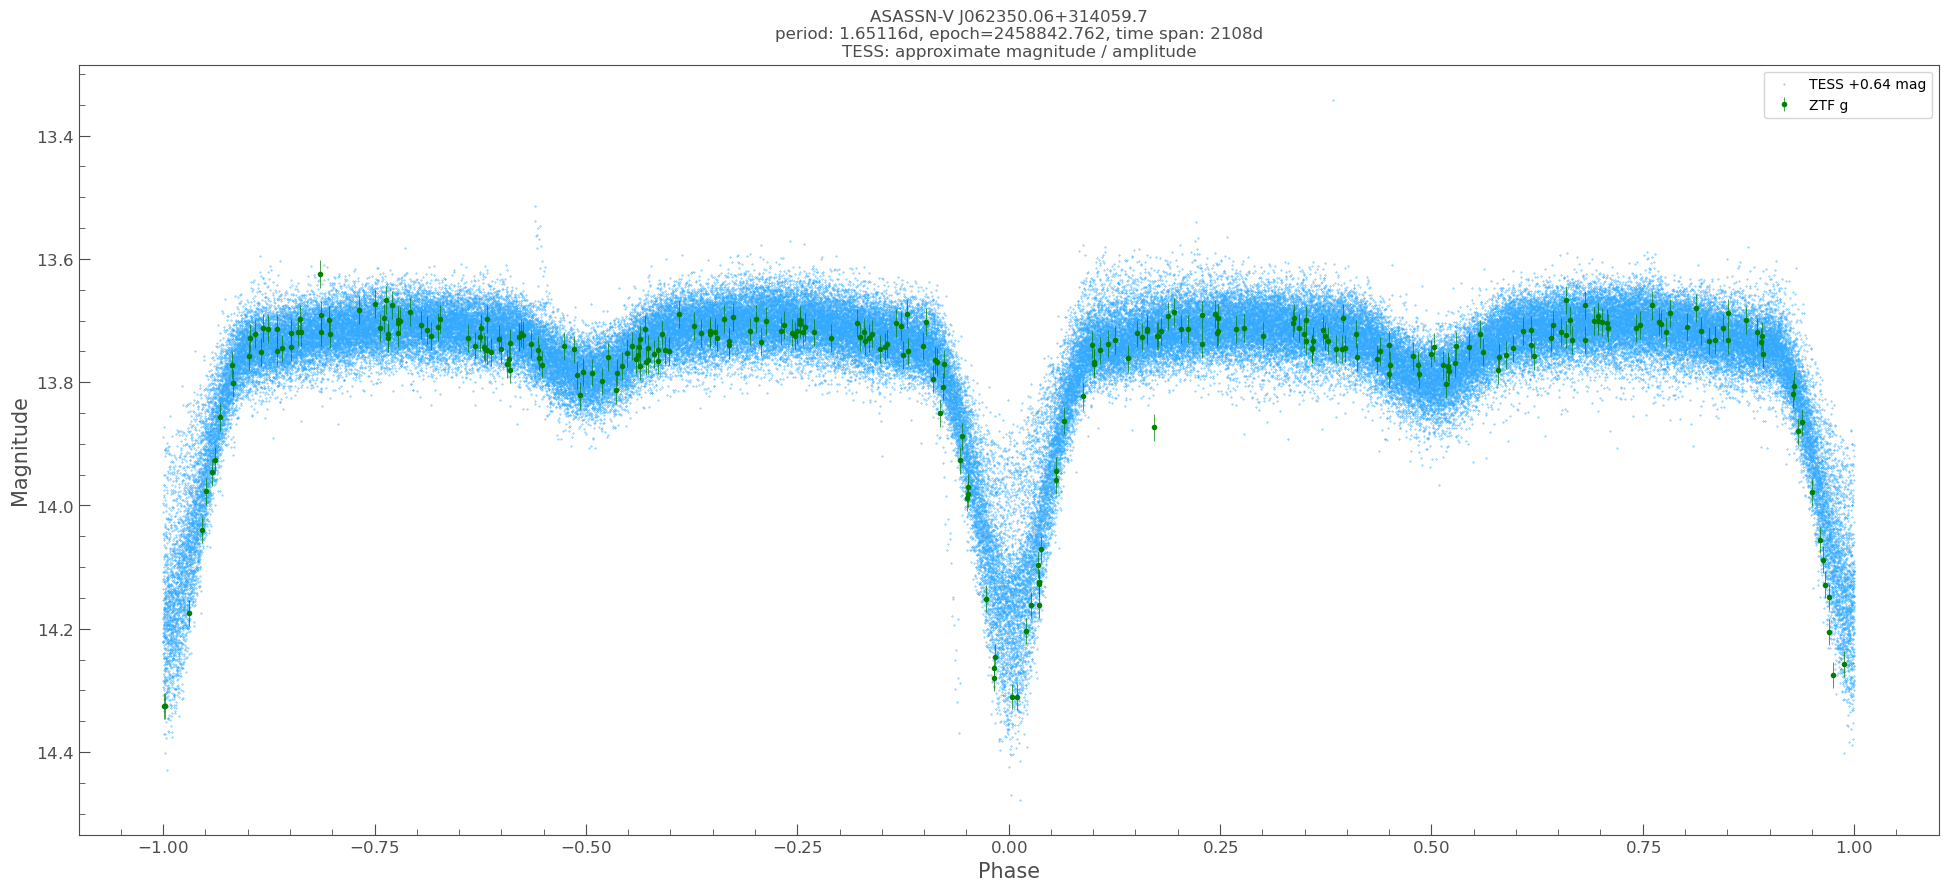

In [57]:
# reload(lkem)
ax, lc_f_res = lkem.fold_n_plot_tess_n_ztf(
    lc_combined_dict,
    period=period_final,
    epoch=Time(epoch_time_hjd, format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_coord=target_coord,
    figsize=(24, 10),
    target_name=primary_name,
    mag_shift_precision=2,  # the TESS lightcurve is very rough anyway
);
ax.set_title(ax.get_title() + "TESS: approximate magnitude / amplitude");

## VSX Report Table

In [15]:
def report_to_df(report):
    df = pd.DataFrame()
    df["Field"] = report.keys()
    df["Value"] = report.values()
    return df

In [68]:
# Nearby companion, TIC TIC 400621146 / Gaia DR3 3438744331224091648
lke.gaia_dr3_mag_to_vmag(12.328997, 1.516150)  

12.780350262034013

In [73]:
import bibs_utils
reload(bibs_utils)


other_names = "Gaia DR3 3438744335522400896,TIC 721936129"  # In Gaia DR3 Variable
# No GSC, https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=I/255/out

remarks = f"Min II mag: {min_ii_flux_mag:.2f} g."
# companion mag: transformed from from Gaia DR3 Gmag and BP-RP Vmag ASAS-SN V 's VMag of 12.26 appears to be too bright (Gaia DR3's GMag is 12.3, Vmag should be fainter)
remarks += ' Visual binary. 12.8 mag. companion 3.7" to the SSE.'  # ~145 deg, E of N

revision_comment = "Identification from ZTF and Gaia DR3 data. Type, period, epoch, eclipse duration from TESS and ZTF DR20. Amplitude from ZTF DR20. Spectral type and position from Gaia DR3."

BIBS = bibs_utils.BIBS

vsx_report = dict(
    Position=f"{target_coord.ra.value}, {target_coord.dec.value}",
    Primary_Name=primary_name,
    Other_Names=other_names,
    Variable_Type="EA",
    Spectral_Type="A",  # from Gaia DR3 astrophysical parameters
    Spectral_Type_Uncertain=False,
    Maximum_Magnitude=f"{max_flux_mag:.2f}",
    Maximum_Magnitude_band="g",  # sloan g , zg
    Minimum_Magnitude=f"{min_flux_mag:.2f}",
    Minimum_Magnitude_band="g",  # sloan g , zg 
    Minimum_Is_Amplitude=False,
    Period=period_final,
    Epoch=epoch_time_hjd,
    Rise_Duration_Pct=f"{100 * duration_hr / 24 / period_final:.0f}",
    Discoverer="",  #  The original entry https://www.aavso.org/vsx/index.php?view=detail.top&oid=625480 has no discoverer
    Remarks=remarks,
    Revision_Comment=revision_comment,
    # Centroid Offset references
    Reference1_Name=BIBS.ZTF_N,
    Reference1_Bib=BIBS.ZTF_B,
    Reference2_Name=BIBS.TESS_N,
    Reference2_Bib=BIBS.TESS_B,
    Reference13_Name=BIBS.TCE_N(2023),   # The sector 42-46 TCE published in 2022 https://archive.stsci.edu/missions/tess/doc/tess_drn/tess_multisector_42_46_drn68_v02.pdf
    Reference13_Link="https://exo.mast.stsci.edu/exomast_planet.html?planet=TIC400621146S0014S0060TCE1",
)

def print_long_fields(report):
    other_names_list = report["Other_Names"].split(",")
    print("Other Names (1 line each):")
    print("\n".join(other_names_list))
    print("")
    print(report["Remarks"])
    print("")
    print(report["Revision_Comment"])

print_long_fields(vsx_report)
with pd.option_context('display.max_colwidth', None):
    display(report_to_df(vsx_report))

# Uploaded plots with  descriptions
print("""
tic721936129_combined_plot.png: Combined light curve - Combined light curve with ZTF g and TESS. TESS is scaled from nearby TIC 400621146, shifted to ZTF g.
tic721936129_phase_plot_eclipses.png : Phase Plot - Phase Plot of the target from ZTF g and TESS. TESS is scaled from nearby TIC 400621146, shifted to ZTF g.
""")


Other Names (1 line each):
Gaia DR3 3438744335522400896
TIC 721936129

Min II mag: 13.80 g. Visual binary. 12.8 mag. companion 3.7" to the SSE.

Identification from ZTF and Gaia DR3 data. Type, period, epoch, eclipse duration from TESS and ZTF DR20. Amplitude from ZTF DR20. Spectral type and position from Gaia DR3.


,Field,Value
0,Position,"95.95788108134, 31.68409665935"
1,Primary_Name,ASASSN-V J062350.06+314059.7
2,Other_Names,"Gaia DR3 3438744335522400896,TIC 721936129"
3,Variable_Type,EA
4,Spectral_Type,A
5,Spectral_Type_Uncertain,False
6,Maximum_Magnitude,13.71
7,Maximum_Magnitude_band,g
8,Minimum_Magnitude,14.33
9,Minimum_Magnitude_band,g



tic721936129_combined_plot.png: Combined light curve - Combined light curve with ZTF g and TESS. TESS is scaled from nearby TIC 400621146, shifted to ZTF g.
tic721936129_phase_plot_eclipses.png : Phase Plot - Phase Plot of the target from ZTF g and TESS. TESS is scaled from nearby TIC 400621146, shifted to ZTF g.



# Scratch